In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[3].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:02<00:00,  3.71it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:20<00:00,  3.03it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|          | 11/2000 [00:01<04:47,  6.92it/s]

Epoch 10/2000, Loss: 0.6624
Test Accuracy at Epoch 10: 53.95%
Test F1-score at Epoch 10: 0.4648
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.54      0.66      0.60       194
non_infringement       0.54      0.41      0.46       186

        accuracy                           0.54       380
       macro avg       0.54      0.54      0.53       380
    weighted avg       0.54      0.54      0.53       380

New best model saved with F1-score 0.4648 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.54      0.66      0.60       194
non_infringement       0.54      0.41      0.46       186

        accuracy                           0.54       380
       macro avg       0.54      0.54      0.53       380
    weighted avg       0.54      0.54      0.53       380



Training Epochs:   1%|          | 21/2000 [00:03<04:52,  6.77it/s]

Epoch 20/2000, Loss: 0.5913
Test Accuracy at Epoch 20: 65.53%
Test F1-score at Epoch 20: 0.6828
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.65       380
    weighted avg       0.66      0.66      0.65       380

New best model saved with F1-score 0.6828 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.65       380
    weighted avg       0.66      0.66      0.65       380



Training Epochs:   2%|▏         | 31/2000 [00:04<03:18,  9.91it/s]

Epoch 30/2000, Loss: 0.4933
Test Accuracy at Epoch 30: 67.37%
Test F1-score at Epoch 30: 0.7005
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       194
non_infringement       0.64      0.78      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380

New best model saved with F1-score 0.7005 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       194
non_infringement       0.64      0.78      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   2%|▏         | 41/2000 [00:05<04:00,  8.15it/s]

Epoch 40/2000, Loss: 0.4183
Test Accuracy at Epoch 40: 70.53%
Test F1-score at Epoch 40: 0.7128
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.73      0.66      0.70       194
non_infringement       0.68      0.75      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.70       380

New best model saved with F1-score 0.7128 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.73      0.66      0.70       194
non_infringement       0.68      0.75      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.70       380



Training Epochs:   3%|▎         | 51/2000 [00:06<03:54,  8.31it/s]

Epoch 50/2000, Loss: 0.3845
Test Accuracy at Epoch 50: 74.21%
Test F1-score at Epoch 50: 0.7586
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

New best model saved with F1-score 0.7586 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:   3%|▎         | 61/2000 [00:07<03:18,  9.75it/s]

Epoch 60/2000, Loss: 0.3652
Test Accuracy at Epoch 60: 74.74%
Test F1-score at Epoch 60: 0.7714
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.87      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380

New best model saved with F1-score 0.7714 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.87      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:   3%|▎         | 69/2000 [00:08<03:09, 10.17it/s]

Epoch 70/2000, Loss: 0.3534
Test Accuracy at Epoch 70: 75.79%
Test F1-score at Epoch 70: 0.7734
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.82      0.68      0.74       194
non_infringement       0.71      0.84      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

New best model saved with F1-score 0.7734 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.82      0.68      0.74       194
non_infringement       0.71      0.84      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:   4%|▍         | 80/2000 [00:09<04:43,  6.78it/s]

Epoch 80/2000, Loss: 0.3442
Test Accuracy at Epoch 80: 76.58%
Test F1-score at Epoch 80: 0.7792
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.77      0.76       380

New best model saved with F1-score 0.7792 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.77      0.76       380



Training Epochs:   5%|▍         | 92/2000 [00:11<03:09, 10.08it/s]

Epoch 90/2000, Loss: 0.3362
Test Accuracy at Epoch 90: 76.32%
Test F1-score at Epoch 90: 0.7772
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:   5%|▌         | 100/2000 [00:13<05:05,  6.22it/s]

Epoch 100/2000, Loss: 0.3290
Test Accuracy at Epoch 100: 75.53%
Test F1-score at Epoch 100: 0.7748
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.83      0.65      0.73       194
non_infringement       0.70      0.86      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:   6%|▌         | 112/2000 [00:14<02:26, 12.90it/s]

Epoch 110/2000, Loss: 0.3208
Test Accuracy at Epoch 110: 75.79%
Test F1-score at Epoch 110: 0.7756
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:   6%|▌         | 122/2000 [00:14<02:12, 14.15it/s]

Epoch 120/2000, Loss: 0.3109
Test Accuracy at Epoch 120: 75.79%
Test F1-score at Epoch 120: 0.7745
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.82      0.67      0.74       194
non_infringement       0.71      0.85      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:   7%|▋         | 132/2000 [00:16<03:23,  9.20it/s]

Epoch 130/2000, Loss: 0.2985
Test Accuracy at Epoch 130: 76.58%
Test F1-score at Epoch 130: 0.7845
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.84      0.66      0.74       194
non_infringement       0.71      0.87      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380

New best model saved with F1-score 0.7845 at epoch 130
Best Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.84      0.66      0.74       194
non_infringement       0.71      0.87      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:   7%|▋         | 140/2000 [00:16<02:53, 10.69it/s]

Epoch 140/2000, Loss: 0.2859
Test Accuracy at Epoch 140: 74.47%
Test F1-score at Epoch 140: 0.7674
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.83      0.63      0.72       194
non_infringement       0.69      0.86      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:   8%|▊         | 152/2000 [00:18<02:24, 12.75it/s]

Epoch 150/2000, Loss: 0.2734
Test Accuracy at Epoch 150: 75.26%
Test F1-score at Epoch 150: 0.7729
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.83      0.65      0.73       194
non_infringement       0.70      0.86      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:   8%|▊         | 162/2000 [00:18<02:21, 12.94it/s]

Epoch 160/2000, Loss: 0.2587
Test Accuracy at Epoch 160: 75.00%
Test F1-score at Epoch 160: 0.7689
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.82      0.65      0.73       194
non_infringement       0.70      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:   9%|▊         | 172/2000 [00:19<02:15, 13.50it/s]

Epoch 170/2000, Loss: 0.2426
Test Accuracy at Epoch 170: 75.53%
Test F1-score at Epoch 170: 0.7748
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.83      0.65      0.73       194
non_infringement       0.70      0.86      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:   9%|▉         | 180/2000 [00:20<02:19, 13.00it/s]

Epoch 180/2000, Loss: 0.2299
Test Accuracy at Epoch 180: 75.53%
Test F1-score at Epoch 180: 0.7748
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.83      0.65      0.73       194
non_infringement       0.70      0.86      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  10%|▉         | 192/2000 [00:21<02:26, 12.31it/s]

Epoch 190/2000, Loss: 0.2140
Test Accuracy at Epoch 190: 75.53%
Test F1-score at Epoch 190: 0.7748
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.83      0.65      0.73       194
non_infringement       0.70      0.86      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  10%|█         | 202/2000 [00:22<02:01, 14.85it/s]

Epoch 200/2000, Loss: 0.2014
Test Accuracy at Epoch 200: 77.63%
Test F1-score at Epoch 200: 0.7901
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.84      0.70      0.76       194
non_infringement       0.73      0.86      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380

New best model saved with F1-score 0.7901 at epoch 200
Best Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.84      0.70      0.76       194
non_infringement       0.73      0.86      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  11%|█         | 212/2000 [00:23<03:52,  7.68it/s]

Epoch 210/2000, Loss: 0.1884
Test Accuracy at Epoch 210: 77.63%
Test F1-score at Epoch 210: 0.7901
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.84      0.70      0.76       194
non_infringement       0.73      0.86      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  11%|█         | 220/2000 [00:24<04:20,  6.84it/s]

Epoch 220/2000, Loss: 0.1773
Test Accuracy at Epoch 220: 76.84%
Test F1-score at Epoch 220: 0.7895
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  12%|█▏        | 232/2000 [00:25<02:40, 10.99it/s]

Epoch 230/2000, Loss: 0.1710
Test Accuracy at Epoch 230: 77.63%
Test F1-score at Epoch 230: 0.7891
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.83      0.70      0.76       194
non_infringement       0.73      0.85      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  12%|█▏        | 242/2000 [00:26<02:06, 13.89it/s]

Epoch 240/2000, Loss: 0.1610
Test Accuracy at Epoch 240: 77.63%
Test F1-score at Epoch 240: 0.7901
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.84      0.70      0.76       194
non_infringement       0.73      0.86      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  13%|█▎        | 251/2000 [00:27<02:35, 11.26it/s]

Epoch 250/2000, Loss: 0.1551
Test Accuracy at Epoch 250: 77.11%
Test F1-score at Epoch 250: 0.7924
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380

New best model saved with F1-score 0.7924 at epoch 250
Best Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  13%|█▎        | 261/2000 [00:28<02:15, 12.83it/s]

Epoch 260/2000, Loss: 0.1504
Test Accuracy at Epoch 260: 77.63%
Test F1-score at Epoch 260: 0.7901
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.84      0.70      0.76       194
non_infringement       0.73      0.86      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  14%|█▎        | 271/2000 [00:29<02:48, 10.27it/s]

Epoch 270/2000, Loss: 0.1446
Test Accuracy at Epoch 270: 77.37%
Test F1-score at Epoch 270: 0.7943
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380

New best model saved with F1-score 0.7943 at epoch 270
Best Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  14%|█▍        | 283/2000 [00:30<02:24, 11.88it/s]

Epoch 280/2000, Loss: 0.1540
Test Accuracy at Epoch 280: 76.84%
Test F1-score at Epoch 280: 0.7915
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.87      0.64      0.74       194
non_infringement       0.71      0.90      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  15%|█▍        | 292/2000 [00:30<02:09, 13.16it/s]

Epoch 290/2000, Loss: 0.1391
Test Accuracy at Epoch 290: 80.79%
Test F1-score at Epoch 290: 0.8142
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.85      0.76      0.80       194
non_infringement       0.77      0.86      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.81       380
    weighted avg       0.81      0.81      0.81       380

New best model saved with F1-score 0.8142 at epoch 290
Best Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.85      0.76      0.80       194
non_infringement       0.77      0.86      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.81       380
    weighted avg       0.81      0.81      0.81       380



Training Epochs:  15%|█▌        | 300/2000 [00:31<02:25, 11.69it/s]

Epoch 300/2000, Loss: 0.1370
Test Accuracy at Epoch 300: 77.11%
Test F1-score at Epoch 300: 0.7924
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  16%|█▌        | 312/2000 [00:32<02:43, 10.35it/s]

Epoch 310/2000, Loss: 0.1347
Test Accuracy at Epoch 310: 76.58%
Test F1-score at Epoch 310: 0.7855
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.85      0.66      0.74       194
non_infringement       0.71      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:  16%|█▌        | 320/2000 [00:33<02:26, 11.45it/s]

Epoch 320/2000, Loss: 0.1324
Test Accuracy at Epoch 320: 77.37%
Test F1-score at Epoch 320: 0.7943
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  17%|█▋        | 332/2000 [00:34<02:25, 11.45it/s]

Epoch 330/2000, Loss: 0.1307
Test Accuracy at Epoch 330: 77.11%
Test F1-score at Epoch 330: 0.7914
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  17%|█▋        | 342/2000 [00:35<02:42, 10.20it/s]

Epoch 340/2000, Loss: 0.1290
Test Accuracy at Epoch 340: 77.11%
Test F1-score at Epoch 340: 0.7914
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  18%|█▊        | 352/2000 [00:36<02:23, 11.45it/s]

Epoch 350/2000, Loss: 0.1275
Test Accuracy at Epoch 350: 77.11%
Test F1-score at Epoch 350: 0.7914
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  18%|█▊        | 361/2000 [00:37<02:47,  9.78it/s]

Epoch 360/2000, Loss: 0.1260
Test Accuracy at Epoch 360: 77.11%
Test F1-score at Epoch 360: 0.7914
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  19%|█▊        | 371/2000 [00:38<02:41, 10.07it/s]

Epoch 370/2000, Loss: 0.1245
Test Accuracy at Epoch 370: 78.42%
Test F1-score at Epoch 370: 0.8010
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  19%|█▉        | 381/2000 [00:39<03:17,  8.20it/s]

Epoch 380/2000, Loss: 0.1263
Test Accuracy at Epoch 380: 76.84%
Test F1-score at Epoch 380: 0.7905
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  20%|█▉        | 390/2000 [00:40<02:55,  9.19it/s]

Epoch 390/2000, Loss: 0.1222
Test Accuracy at Epoch 390: 76.84%
Test F1-score at Epoch 390: 0.7895
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  20%|██        | 401/2000 [00:41<02:24, 11.07it/s]

Epoch 400/2000, Loss: 0.1221
Test Accuracy at Epoch 400: 76.58%
Test F1-score at Epoch 400: 0.7876
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:  21%|██        | 413/2000 [00:42<02:05, 12.67it/s]

Epoch 410/2000, Loss: 0.1222
Test Accuracy at Epoch 410: 78.16%
Test F1-score at Epoch 410: 0.7990
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  21%|██        | 421/2000 [00:43<01:52, 14.07it/s]

Epoch 420/2000, Loss: 0.1210
Test Accuracy at Epoch 420: 78.42%
Test F1-score at Epoch 420: 0.8010
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  22%|██▏       | 431/2000 [00:43<01:46, 14.70it/s]

Epoch 430/2000, Loss: 0.1197
Test Accuracy at Epoch 430: 78.42%
Test F1-score at Epoch 430: 0.8010
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  22%|██▏       | 442/2000 [00:44<01:37, 15.99it/s]

Epoch 440/2000, Loss: 0.1182
Test Accuracy at Epoch 440: 78.42%
Test F1-score at Epoch 440: 0.8010
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  23%|██▎       | 452/2000 [00:45<01:37, 15.91it/s]

Epoch 450/2000, Loss: 0.1172
Test Accuracy at Epoch 450: 78.16%
Test F1-score at Epoch 450: 0.7990
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  23%|██▎       | 462/2000 [00:45<01:42, 14.97it/s]

Epoch 460/2000, Loss: 0.1162
Test Accuracy at Epoch 460: 80.00%
Test F1-score at Epoch 460: 0.8128
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.87      0.72      0.79       194
non_infringement       0.75      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  24%|██▎       | 470/2000 [00:46<01:42, 14.98it/s]

Epoch 470/2000, Loss: 0.1154
Test Accuracy at Epoch 470: 80.00%
Test F1-score at Epoch 470: 0.8128
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.87      0.72      0.79       194
non_infringement       0.75      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  24%|██▍       | 482/2000 [00:47<01:48, 13.94it/s]

Epoch 480/2000, Loss: 0.1147
Test Accuracy at Epoch 480: 80.00%
Test F1-score at Epoch 480: 0.8128
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.87      0.72      0.79       194
non_infringement       0.75      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  25%|██▍       | 492/2000 [00:48<01:56, 12.94it/s]

Epoch 490/2000, Loss: 0.1147
Test Accuracy at Epoch 490: 81.32%
Test F1-score at Epoch 490: 0.8212
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.86      0.75      0.80       194
non_infringement       0.77      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380

New best model saved with F1-score 0.8212 at epoch 490
Best Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.86      0.75      0.80       194
non_infringement       0.77      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  25%|██▌       | 502/2000 [00:48<01:39, 15.02it/s]

Epoch 500/2000, Loss: 0.1134
Test Accuracy at Epoch 500: 78.16%
Test F1-score at Epoch 500: 0.7990
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  26%|██▌       | 513/2000 [00:49<01:16, 19.33it/s]

Epoch 510/2000, Loss: 0.1148
Test Accuracy at Epoch 510: 81.32%
Test F1-score at Epoch 510: 0.8212
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.86      0.75      0.80       194
non_infringement       0.77      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  26%|██▌       | 523/2000 [00:49<01:17, 19.15it/s]

Epoch 520/2000, Loss: 0.1125
Test Accuracy at Epoch 520: 79.74%
Test F1-score at Epoch 520: 0.8108
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.75      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  27%|██▋       | 532/2000 [00:50<01:21, 18.04it/s]

Epoch 530/2000, Loss: 0.1117
Test Accuracy at Epoch 530: 79.47%
Test F1-score at Epoch 530: 0.8069
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  27%|██▋       | 541/2000 [00:50<01:09, 21.07it/s]

Epoch 540/2000, Loss: 0.1114
Test Accuracy at Epoch 540: 79.74%
Test F1-score at Epoch 540: 0.8108
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.75      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  28%|██▊       | 553/2000 [00:51<01:06, 21.88it/s]

Epoch 550/2000, Loss: 0.1110
Test Accuracy at Epoch 550: 79.74%
Test F1-score at Epoch 550: 0.8108
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.75      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  28%|██▊       | 565/2000 [00:51<00:58, 24.69it/s]

Epoch 560/2000, Loss: 0.1135
Test Accuracy at Epoch 560: 77.37%
Test F1-score at Epoch 560: 0.7933
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  29%|██▉       | 576/2000 [00:52<00:53, 26.83it/s]

Epoch 570/2000, Loss: 0.1120
Test Accuracy at Epoch 570: 81.05%
Test F1-score at Epoch 570: 0.8182
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.86      0.75      0.80       194
non_infringement       0.77      0.87      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  29%|██▉       | 582/2000 [00:52<01:03, 22.26it/s]

Epoch 580/2000, Loss: 0.1100
Test Accuracy at Epoch 580: 79.21%
Test F1-score at Epoch 580: 0.8068
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.87      0.70      0.77       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  30%|██▉       | 591/2000 [00:52<01:06, 21.08it/s]

Epoch 590/2000, Loss: 0.1088
Test Accuracy at Epoch 590: 79.47%
Test F1-score at Epoch 590: 0.8069
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  30%|███       | 600/2000 [00:53<01:08, 20.41it/s]

Epoch 600/2000, Loss: 0.1098
Test Accuracy at Epoch 600: 81.58%
Test F1-score at Epoch 600: 0.8223
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.86      0.76      0.81       194
non_infringement       0.78      0.87      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380

New best model saved with F1-score 0.8223 at epoch 600
Best Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.86      0.76      0.81       194
non_infringement       0.78      0.87      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  31%|███       | 611/2000 [00:53<01:20, 17.16it/s]

Epoch 610/2000, Loss: 0.1081
Test Accuracy at Epoch 610: 79.21%
Test F1-score at Epoch 610: 0.8068
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.87      0.70      0.77       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  31%|███       | 622/2000 [00:54<01:08, 20.13it/s]

Epoch 620/2000, Loss: 0.1096
Test Accuracy at Epoch 620: 78.68%
Test F1-score at Epoch 620: 0.8029
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  32%|███▏      | 631/2000 [00:54<00:58, 23.44it/s]

Epoch 630/2000, Loss: 0.1082
Test Accuracy at Epoch 630: 81.32%
Test F1-score at Epoch 630: 0.8203
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.86      0.76      0.81       194
non_infringement       0.78      0.87      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  32%|███▏      | 640/2000 [00:55<01:04, 21.02it/s]

Epoch 640/2000, Loss: 0.1074
Test Accuracy at Epoch 640: 78.68%
Test F1-score at Epoch 640: 0.8000
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  33%|███▎      | 651/2000 [00:56<01:26, 15.61it/s]

Epoch 650/2000, Loss: 0.1075
Test Accuracy at Epoch 650: 78.68%
Test F1-score at Epoch 650: 0.8029
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  33%|███▎      | 661/2000 [00:56<01:55, 11.61it/s]

Epoch 660/2000, Loss: 0.1073
Test Accuracy at Epoch 660: 78.68%
Test F1-score at Epoch 660: 0.8020
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  34%|███▎      | 673/2000 [00:58<01:47, 12.29it/s]

Epoch 670/2000, Loss: 0.1079
Test Accuracy at Epoch 670: 81.32%
Test F1-score at Epoch 670: 0.8203
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.86      0.76      0.81       194
non_infringement       0.78      0.87      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  34%|███▍      | 681/2000 [00:58<01:46, 12.39it/s]

Epoch 680/2000, Loss: 0.1068
Test Accuracy at Epoch 680: 78.95%
Test F1-score at Epoch 680: 0.8058
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  35%|███▍      | 693/2000 [00:59<01:31, 14.27it/s]

Epoch 690/2000, Loss: 0.1058
Test Accuracy at Epoch 690: 78.95%
Test F1-score at Epoch 690: 0.8039
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  35%|███▌      | 700/2000 [01:00<01:33, 13.91it/s]

Epoch 700/2000, Loss: 0.1057
Test Accuracy at Epoch 700: 79.47%
Test F1-score at Epoch 700: 0.8060
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.85      0.72      0.78       194
non_infringement       0.75      0.87      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  36%|███▌      | 712/2000 [01:01<01:42, 12.57it/s]

Epoch 710/2000, Loss: 0.1091
Test Accuracy at Epoch 710: 81.05%
Test F1-score at Epoch 710: 0.8173
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.85      0.76      0.80       194
non_infringement       0.77      0.87      0.82       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  36%|███▌      | 720/2000 [01:01<01:44, 12.26it/s]

Epoch 720/2000, Loss: 0.1073
Test Accuracy at Epoch 720: 77.37%
Test F1-score at Epoch 720: 0.7943
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  37%|███▋      | 733/2000 [01:02<01:29, 14.08it/s]

Epoch 730/2000, Loss: 0.1061
Test Accuracy at Epoch 730: 81.84%
Test F1-score at Epoch 730: 0.8262
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380

New best model saved with F1-score 0.8262 at epoch 730
Best Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  37%|███▋      | 742/2000 [01:03<01:49, 11.53it/s]

Epoch 740/2000, Loss: 0.1048
Test Accuracy at Epoch 740: 79.21%
Test F1-score at Epoch 740: 0.8078
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.87      0.70      0.77       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  38%|███▊      | 752/2000 [01:04<01:53, 11.03it/s]

Epoch 750/2000, Loss: 0.1047
Test Accuracy at Epoch 750: 79.74%
Test F1-score at Epoch 750: 0.8117
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  38%|███▊      | 761/2000 [01:05<01:27, 14.14it/s]

Epoch 760/2000, Loss: 0.1041
Test Accuracy at Epoch 760: 79.21%
Test F1-score at Epoch 760: 0.8059
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.74      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  39%|███▊      | 774/2000 [01:06<01:11, 17.24it/s]

Epoch 770/2000, Loss: 0.1058
Test Accuracy at Epoch 770: 77.37%
Test F1-score at Epoch 770: 0.7943
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  39%|███▉      | 781/2000 [01:06<01:21, 14.98it/s]

Epoch 780/2000, Loss: 0.1044
Test Accuracy at Epoch 780: 81.05%
Test F1-score at Epoch 780: 0.8182
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.86      0.75      0.80       194
non_infringement       0.77      0.87      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  40%|███▉      | 792/2000 [01:07<01:17, 15.63it/s]

Epoch 790/2000, Loss: 0.1046
Test Accuracy at Epoch 790: 79.21%
Test F1-score at Epoch 790: 0.8078
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.87      0.70      0.77       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  40%|████      | 802/2000 [01:08<01:28, 13.54it/s]

Epoch 800/2000, Loss: 0.1043
Test Accuracy at Epoch 800: 81.05%
Test F1-score at Epoch 800: 0.8182
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.86      0.75      0.80       194
non_infringement       0.77      0.87      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  40%|████      | 810/2000 [01:08<01:51, 10.66it/s]

Epoch 810/2000, Loss: 0.1036
Test Accuracy at Epoch 810: 79.74%
Test F1-score at Epoch 810: 0.8117
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  41%|████      | 821/2000 [01:09<01:18, 15.02it/s]

Epoch 820/2000, Loss: 0.1029
Test Accuracy at Epoch 820: 79.47%
Test F1-score at Epoch 820: 0.8079
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  42%|████▏     | 832/2000 [01:10<01:11, 16.33it/s]

Epoch 830/2000, Loss: 0.1032
Test Accuracy at Epoch 830: 79.47%
Test F1-score at Epoch 830: 0.8069
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  42%|████▏     | 842/2000 [01:11<01:39, 11.61it/s]

Epoch 840/2000, Loss: 0.1032
Test Accuracy at Epoch 840: 79.47%
Test F1-score at Epoch 840: 0.8069
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  42%|████▎     | 850/2000 [01:11<01:46, 10.82it/s]

Epoch 850/2000, Loss: 0.1040
Test Accuracy at Epoch 850: 81.05%
Test F1-score at Epoch 850: 0.8182
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.86      0.75      0.80       194
non_infringement       0.77      0.87      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  43%|████▎     | 863/2000 [01:13<01:35, 11.89it/s]

Epoch 860/2000, Loss: 0.1024
Test Accuracy at Epoch 860: 79.47%
Test F1-score at Epoch 860: 0.8079
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  44%|████▎     | 871/2000 [01:13<01:32, 12.18it/s]

Epoch 870/2000, Loss: 0.1021
Test Accuracy at Epoch 870: 79.21%
Test F1-score at Epoch 870: 0.8059
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.74      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  44%|████▍     | 882/2000 [01:15<02:03,  9.07it/s]

Epoch 880/2000, Loss: 0.1024
Test Accuracy at Epoch 880: 79.74%
Test F1-score at Epoch 880: 0.8117
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  44%|████▍     | 890/2000 [01:16<01:35, 11.63it/s]

Epoch 890/2000, Loss: 0.1024
Test Accuracy at Epoch 890: 79.21%
Test F1-score at Epoch 890: 0.8049
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  45%|████▌     | 902/2000 [01:17<01:31, 12.06it/s]

Epoch 900/2000, Loss: 0.1034
Test Accuracy at Epoch 900: 77.11%
Test F1-score at Epoch 900: 0.7924
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  46%|████▌     | 910/2000 [01:17<01:25, 12.78it/s]

Epoch 910/2000, Loss: 0.1033
Test Accuracy at Epoch 910: 81.05%
Test F1-score at Epoch 910: 0.8182
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.86      0.75      0.80       194
non_infringement       0.77      0.87      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  46%|████▌     | 922/2000 [01:18<01:18, 13.72it/s]

Epoch 920/2000, Loss: 0.1018
Test Accuracy at Epoch 920: 79.21%
Test F1-score at Epoch 920: 0.8059
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.74      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  47%|████▋     | 931/2000 [01:19<01:07, 15.82it/s]

Epoch 930/2000, Loss: 0.1014
Test Accuracy at Epoch 930: 79.21%
Test F1-score at Epoch 930: 0.8049
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  47%|████▋     | 941/2000 [01:20<01:33, 11.29it/s]

Epoch 940/2000, Loss: 0.1013
Test Accuracy at Epoch 940: 79.21%
Test F1-score at Epoch 940: 0.8059
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.74      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  47%|████▋     | 949/2000 [01:20<01:12, 14.45it/s]

Epoch 950/2000, Loss: 0.1010
Test Accuracy at Epoch 950: 79.21%
Test F1-score at Epoch 950: 0.8049
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  48%|████▊     | 963/2000 [01:21<01:04, 16.02it/s]

Epoch 960/2000, Loss: 0.1011
Test Accuracy at Epoch 960: 78.95%
Test F1-score at Epoch 960: 0.8020
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.78       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  49%|████▊     | 973/2000 [01:22<01:04, 16.02it/s]

Epoch 970/2000, Loss: 0.1035
Test Accuracy at Epoch 970: 80.53%
Test F1-score at Epoch 970: 0.8131
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  49%|████▉     | 982/2000 [01:23<00:52, 19.41it/s]

Epoch 980/2000, Loss: 0.1008
Test Accuracy at Epoch 980: 79.21%
Test F1-score at Epoch 980: 0.8059
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.74      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  50%|████▉     | 993/2000 [01:23<00:41, 24.37it/s]

Epoch 990/2000, Loss: 0.1022
Test Accuracy at Epoch 990: 79.74%
Test F1-score at Epoch 990: 0.8117
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  50%|█████     | 1007/2000 [01:23<00:29, 34.19it/s]

Epoch 1000/2000, Loss: 0.1013
Test Accuracy at Epoch 1000: 80.53%
Test F1-score at Epoch 1000: 0.8131
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  51%|█████     | 1015/2000 [01:24<00:29, 33.14it/s]

Epoch 1010/2000, Loss: 0.1007
Test Accuracy at Epoch 1010: 78.68%
Test F1-score at Epoch 1010: 0.7990
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  51%|█████     | 1024/2000 [01:24<00:29, 33.08it/s]

Epoch 1020/2000, Loss: 0.1011
Test Accuracy at Epoch 1020: 79.74%
Test F1-score at Epoch 1020: 0.8117
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  52%|█████▏    | 1036/2000 [01:24<00:29, 33.06it/s]

Epoch 1030/2000, Loss: 0.1007
Test Accuracy at Epoch 1030: 78.95%
Test F1-score at Epoch 1030: 0.8030
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  52%|█████▏    | 1044/2000 [01:24<00:29, 32.49it/s]

Epoch 1040/2000, Loss: 0.1006
Test Accuracy at Epoch 1040: 80.53%
Test F1-score at Epoch 1040: 0.8131
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  53%|█████▎    | 1056/2000 [01:25<00:28, 33.06it/s]

Epoch 1050/2000, Loss: 0.1015
Test Accuracy at Epoch 1050: 80.53%
Test F1-score at Epoch 1050: 0.8131
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  53%|█████▎    | 1060/2000 [01:25<00:31, 30.17it/s]

Epoch 1060/2000, Loss: 0.1006
Test Accuracy at Epoch 1060: 79.74%
Test F1-score at Epoch 1060: 0.8117
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  54%|█████▎    | 1073/2000 [01:26<00:39, 23.32it/s]

Epoch 1070/2000, Loss: 0.1003
Test Accuracy at Epoch 1070: 78.68%
Test F1-score at Epoch 1070: 0.8000
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  54%|█████▍    | 1083/2000 [01:26<00:36, 25.35it/s]

Epoch 1080/2000, Loss: 0.1010
Test Accuracy at Epoch 1080: 80.53%
Test F1-score at Epoch 1080: 0.8131
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  55%|█████▍    | 1092/2000 [01:26<00:40, 22.18it/s]

Epoch 1090/2000, Loss: 0.0996
Test Accuracy at Epoch 1090: 78.95%
Test F1-score at Epoch 1090: 0.8020
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.78       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  55%|█████▌    | 1104/2000 [01:27<00:51, 17.27it/s]

Epoch 1100/2000, Loss: 0.1011
Test Accuracy at Epoch 1100: 77.63%
Test F1-score at Epoch 1100: 0.7962
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  56%|█████▌    | 1113/2000 [01:28<00:46, 19.09it/s]

Epoch 1110/2000, Loss: 0.0994
Test Accuracy at Epoch 1110: 78.68%
Test F1-score at Epoch 1110: 0.8000
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  56%|█████▌    | 1118/2000 [01:28<01:13, 12.05it/s]

Epoch 1120/2000, Loss: 0.1010
Test Accuracy at Epoch 1120: 80.53%
Test F1-score at Epoch 1120: 0.8131
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  57%|█████▋    | 1133/2000 [01:29<00:48, 18.02it/s]

Epoch 1130/2000, Loss: 0.0993
Test Accuracy at Epoch 1130: 78.68%
Test F1-score at Epoch 1130: 0.8000
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  57%|█████▋    | 1142/2000 [01:30<00:53, 15.93it/s]

Epoch 1140/2000, Loss: 0.1009
Test Accuracy at Epoch 1140: 77.63%
Test F1-score at Epoch 1140: 0.7962
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  58%|█████▊    | 1154/2000 [01:30<00:38, 22.06it/s]

Epoch 1150/2000, Loss: 0.0991
Test Accuracy at Epoch 1150: 78.68%
Test F1-score at Epoch 1150: 0.7990
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  58%|█████▊    | 1163/2000 [01:30<00:35, 23.54it/s]

Epoch 1160/2000, Loss: 0.1010
Test Accuracy at Epoch 1160: 80.53%
Test F1-score at Epoch 1160: 0.8131
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  59%|█████▊    | 1172/2000 [01:31<00:41, 19.86it/s]

Epoch 1170/2000, Loss: 0.0989
Test Accuracy at Epoch 1170: 78.68%
Test F1-score at Epoch 1170: 0.8000
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  59%|█████▉    | 1181/2000 [01:31<00:38, 21.01it/s]

Epoch 1180/2000, Loss: 0.1009
Test Accuracy at Epoch 1180: 77.37%
Test F1-score at Epoch 1180: 0.7933
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  60%|█████▉    | 1191/2000 [01:32<00:41, 19.48it/s]

Epoch 1190/2000, Loss: 0.0988
Test Accuracy at Epoch 1190: 78.68%
Test F1-score at Epoch 1190: 0.7990
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  60%|██████    | 1204/2000 [01:32<00:32, 24.21it/s]

Epoch 1200/2000, Loss: 0.1009
Test Accuracy at Epoch 1200: 80.53%
Test F1-score at Epoch 1200: 0.8131
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  61%|██████    | 1214/2000 [01:33<00:30, 25.59it/s]

Epoch 1210/2000, Loss: 0.0987
Test Accuracy at Epoch 1210: 78.68%
Test F1-score at Epoch 1210: 0.8000
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  61%|██████    | 1223/2000 [01:33<00:31, 24.73it/s]

Epoch 1220/2000, Loss: 0.1007
Test Accuracy at Epoch 1220: 78.95%
Test F1-score at Epoch 1220: 0.8049
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.87      0.70      0.77       194
non_infringement       0.74      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  62%|██████▏   | 1235/2000 [01:33<00:30, 25.02it/s]

Epoch 1230/2000, Loss: 0.0986
Test Accuracy at Epoch 1230: 78.68%
Test F1-score at Epoch 1230: 0.7990
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  62%|██████▏   | 1245/2000 [01:34<00:26, 27.98it/s]

Epoch 1240/2000, Loss: 0.1005
Test Accuracy at Epoch 1240: 80.53%
Test F1-score at Epoch 1240: 0.8131
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  63%|██████▎   | 1253/2000 [01:34<00:27, 26.79it/s]

Epoch 1250/2000, Loss: 0.0985
Test Accuracy at Epoch 1250: 78.68%
Test F1-score at Epoch 1250: 0.8000
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  63%|██████▎   | 1261/2000 [01:34<00:23, 31.92it/s]

Epoch 1260/2000, Loss: 0.1002
Test Accuracy at Epoch 1260: 78.95%
Test F1-score at Epoch 1260: 0.8049
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.87      0.70      0.77       194
non_infringement       0.74      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  64%|██████▎   | 1274/2000 [01:35<00:23, 30.81it/s]

Epoch 1270/2000, Loss: 0.0985
Test Accuracy at Epoch 1270: 78.68%
Test F1-score at Epoch 1270: 0.7990
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  64%|██████▍   | 1284/2000 [01:35<00:28, 25.31it/s]

Epoch 1280/2000, Loss: 0.1000
Test Accuracy at Epoch 1280: 80.53%
Test F1-score at Epoch 1280: 0.8131
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  65%|██████▍   | 1295/2000 [01:36<00:24, 28.79it/s]

Epoch 1290/2000, Loss: 0.0984
Test Accuracy at Epoch 1290: 78.68%
Test F1-score at Epoch 1290: 0.8000
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  65%|██████▌   | 1305/2000 [01:36<00:23, 29.78it/s]

Epoch 1300/2000, Loss: 0.0997
Test Accuracy at Epoch 1300: 78.68%
Test F1-score at Epoch 1300: 0.8020
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  66%|██████▌   | 1317/2000 [01:36<00:21, 31.84it/s]

Epoch 1310/2000, Loss: 0.0982
Test Accuracy at Epoch 1310: 78.68%
Test F1-score at Epoch 1310: 0.7990
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  66%|██████▌   | 1321/2000 [01:37<00:24, 28.16it/s]

Epoch 1320/2000, Loss: 0.0997
Test Accuracy at Epoch 1320: 80.53%
Test F1-score at Epoch 1320: 0.8131
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  67%|██████▋   | 1334/2000 [01:37<00:20, 32.21it/s]

Epoch 1330/2000, Loss: 0.0981
Test Accuracy at Epoch 1330: 78.16%
Test F1-score at Epoch 1330: 0.7961
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.76       194
non_infringement       0.73      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  67%|██████▋   | 1347/2000 [01:37<00:16, 38.88it/s]

Epoch 1340/2000, Loss: 0.0996
Test Accuracy at Epoch 1340: 78.68%
Test F1-score at Epoch 1340: 0.8020
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  68%|██████▊   | 1357/2000 [01:37<00:16, 39.99it/s]

Epoch 1350/2000, Loss: 0.0979
Test Accuracy at Epoch 1350: 78.68%
Test F1-score at Epoch 1350: 0.7990
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  68%|██████▊   | 1368/2000 [01:38<00:15, 41.41it/s]

Epoch 1360/2000, Loss: 0.0997
Test Accuracy at Epoch 1360: 80.53%
Test F1-score at Epoch 1360: 0.8131
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  69%|██████▉   | 1379/2000 [01:38<00:14, 43.44it/s]

Epoch 1370/2000, Loss: 0.0977
Test Accuracy at Epoch 1370: 78.68%
Test F1-score at Epoch 1370: 0.8000
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  69%|██████▉   | 1384/2000 [01:38<00:16, 37.35it/s]

Epoch 1380/2000, Loss: 0.0997
Test Accuracy at Epoch 1380: 77.37%
Test F1-score at Epoch 1380: 0.7933
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  70%|██████▉   | 1394/2000 [01:38<00:15, 40.06it/s]

Epoch 1390/2000, Loss: 0.0975
Test Accuracy at Epoch 1390: 78.68%
Test F1-score at Epoch 1390: 0.7990
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  70%|███████   | 1403/2000 [01:39<00:17, 34.22it/s]

Epoch 1400/2000, Loss: 0.0996
Test Accuracy at Epoch 1400: 80.53%
Test F1-score at Epoch 1400: 0.8131
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  71%|███████   | 1412/2000 [01:39<00:17, 33.28it/s]

Epoch 1410/2000, Loss: 0.0974
Test Accuracy at Epoch 1410: 78.42%
Test F1-score at Epoch 1410: 0.7970
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  71%|███████   | 1421/2000 [01:39<00:16, 34.96it/s]

Epoch 1420/2000, Loss: 0.0992
Test Accuracy at Epoch 1420: 77.37%
Test F1-score at Epoch 1420: 0.7933
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  72%|███████▏  | 1435/2000 [01:40<00:15, 35.96it/s]

Epoch 1430/2000, Loss: 0.0973
Test Accuracy at Epoch 1430: 78.42%
Test F1-score at Epoch 1430: 0.7970
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  72%|███████▏  | 1448/2000 [01:40<00:14, 37.24it/s]

Epoch 1440/2000, Loss: 0.0988
Test Accuracy at Epoch 1440: 80.53%
Test F1-score at Epoch 1440: 0.8131
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  73%|███████▎  | 1452/2000 [01:40<00:16, 32.34it/s]

Epoch 1450/2000, Loss: 0.0974
Test Accuracy at Epoch 1450: 78.68%
Test F1-score at Epoch 1450: 0.7990
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  73%|███████▎  | 1466/2000 [01:41<00:15, 34.46it/s]

Epoch 1460/2000, Loss: 0.0982
Test Accuracy at Epoch 1460: 78.68%
Test F1-score at Epoch 1460: 0.8020
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  74%|███████▍  | 1476/2000 [01:41<00:13, 38.55it/s]

Epoch 1470/2000, Loss: 0.0977
Test Accuracy at Epoch 1470: 78.16%
Test F1-score at Epoch 1470: 0.7961
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.76       194
non_infringement       0.73      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  74%|███████▍  | 1481/2000 [01:41<00:14, 35.08it/s]

Epoch 1480/2000, Loss: 0.0977
Test Accuracy at Epoch 1480: 80.53%
Test F1-score at Epoch 1480: 0.8131
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  75%|███████▍  | 1495/2000 [01:41<00:14, 34.28it/s]

Epoch 1490/2000, Loss: 0.0983
Test Accuracy at Epoch 1490: 80.53%
Test F1-score at Epoch 1490: 0.8131
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  75%|███████▌  | 1505/2000 [01:42<00:12, 38.33it/s]

Epoch 1500/2000, Loss: 0.0973
Test Accuracy at Epoch 1500: 78.16%
Test F1-score at Epoch 1500: 0.7961
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.76       194
non_infringement       0.73      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  76%|███████▌  | 1515/2000 [01:42<00:13, 36.96it/s]

Epoch 1510/2000, Loss: 0.0988
Test Accuracy at Epoch 1510: 78.95%
Test F1-score at Epoch 1510: 0.8049
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.87      0.70      0.77       194
non_infringement       0.74      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  76%|███████▋  | 1525/2000 [01:42<00:13, 35.17it/s]

Epoch 1520/2000, Loss: 0.0970
Test Accuracy at Epoch 1520: 78.68%
Test F1-score at Epoch 1520: 0.7990
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  77%|███████▋  | 1535/2000 [01:42<00:11, 40.28it/s]

Epoch 1530/2000, Loss: 0.0990
Test Accuracy at Epoch 1530: 80.53%
Test F1-score at Epoch 1530: 0.8131
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  77%|███████▋  | 1545/2000 [01:43<00:11, 40.60it/s]

Epoch 1540/2000, Loss: 0.0968
Test Accuracy at Epoch 1540: 78.42%
Test F1-score at Epoch 1540: 0.7970
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  78%|███████▊  | 1557/2000 [01:43<00:09, 47.02it/s]

Epoch 1550/2000, Loss: 0.0986
Test Accuracy at Epoch 1550: 77.63%
Test F1-score at Epoch 1550: 0.7962
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  78%|███████▊  | 1568/2000 [01:43<00:09, 45.84it/s]

Epoch 1560/2000, Loss: 0.0967
Test Accuracy at Epoch 1560: 78.42%
Test F1-score at Epoch 1560: 0.7970
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380

Epoch 1570/2000, Loss: 0.0980
Test Accuracy at Epoch 1570: 80.53%
Test F1-score at Epoch 1570: 0.8131


Training Epochs:  79%|███████▊  | 1573/2000 [01:43<00:09, 46.60it/s]

Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  79%|███████▉  | 1589/2000 [01:44<00:08, 46.60it/s]

Epoch 1580/2000, Loss: 0.0970
Test Accuracy at Epoch 1580: 78.68%
Test F1-score at Epoch 1580: 0.7990
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380

Epoch 1590/2000, Loss: 0.0973
Test Accuracy at Epoch 1590: 78.42%
Test F1-score at Epoch 1590: 0.7990


Training Epochs:  80%|███████▉  | 1594/2000 [01:44<00:08, 46.98it/s]

Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  80%|████████  | 1605/2000 [01:44<00:08, 46.37it/s]

Epoch 1600/2000, Loss: 0.0975
Test Accuracy at Epoch 1600: 78.42%
Test F1-score at Epoch 1600: 0.7990
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380

Epoch 1610/2000, Loss: 0.0969
Test Accuracy at Epoch 1610: 78.68%
Test F1-score at Epoch 1610: 0.7990
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  81%|████████▏ | 1629/2000 [01:44<00:07, 49.44it/s]

Epoch 1620/2000, Loss: 0.0983
Test Accuracy at Epoch 1620: 80.79%
Test F1-score at Epoch 1620: 0.8152
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.85      0.75      0.80       194
non_infringement       0.77      0.87      0.82       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.81       380
    weighted avg       0.81      0.81      0.81       380

Epoch 1630/2000, Loss: 0.0965
Test Accuracy at Epoch 1630: 78.16%
Test F1-score at Epoch 1630: 0.7961
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.76       194
non_infringement       0.73      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  82%|████████▏ | 1648/2000 [01:45<00:06, 51.50it/s]

Epoch 1640/2000, Loss: 0.0985
Test Accuracy at Epoch 1640: 77.63%
Test F1-score at Epoch 1640: 0.7962
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 1650/2000, Loss: 0.0963
Test Accuracy at Epoch 1650: 78.95%
Test F1-score at Epoch 1650: 0.8020
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.78       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  83%|████████▎ | 1666/2000 [01:45<00:06, 49.39it/s]

Epoch 1660/2000, Loss: 0.0982
Test Accuracy at Epoch 1660: 79.47%
Test F1-score at Epoch 1660: 0.8000
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.83      0.75      0.79       194
non_infringement       0.76      0.84      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380

Epoch 1670/2000, Loss: 0.0963
Test Accuracy at Epoch 1670: 78.95%
Test F1-score at Epoch 1670: 0.8020
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.85      0.71      0.78       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  84%|████████▍ | 1685/2000 [01:46<00:06, 51.16it/s]

Epoch 1680/2000, Loss: 0.0974
Test Accuracy at Epoch 1680: 78.16%
Test F1-score at Epoch 1680: 0.7971
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380

Epoch 1690/2000, Loss: 0.0967
Test Accuracy at Epoch 1690: 78.16%
Test F1-score at Epoch 1690: 0.7961
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.76       194
non_infringement       0.73      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  86%|████████▌ | 1710/2000 [01:46<00:05, 54.50it/s]

Epoch 1700/2000, Loss: 0.0969
Test Accuracy at Epoch 1700: 79.47%
Test F1-score at Epoch 1700: 0.8000
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.83      0.75      0.79       194
non_infringement       0.76      0.84      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380

Epoch 1710/2000, Loss: 0.0973
Test Accuracy at Epoch 1710: 79.47%
Test F1-score at Epoch 1710: 0.8000
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.83      0.75      0.79       194
non_infringement       0.76      0.84      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  86%|████████▋ | 1729/2000 [01:46<00:04, 54.37it/s]

Epoch 1720/2000, Loss: 0.0964
Test Accuracy at Epoch 1720: 78.42%
Test F1-score at Epoch 1720: 0.7990
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380

Epoch 1730/2000, Loss: 0.0978
Test Accuracy at Epoch 1730: 78.16%
Test F1-score at Epoch 1730: 0.7971
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  87%|████████▋ | 1748/2000 [01:47<00:04, 53.47it/s]

Epoch 1740/2000, Loss: 0.0962
Test Accuracy at Epoch 1740: 77.89%
Test F1-score at Epoch 1740: 0.7889
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.83      0.72      0.77       194
non_infringement       0.74      0.84      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380

Epoch 1750/2000, Loss: 0.0982
Test Accuracy at Epoch 1750: 79.74%
Test F1-score at Epoch 1750: 0.8031
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.83      0.75      0.79       194
non_infringement       0.77      0.84      0.80       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380



Training Epochs:  88%|████████▊ | 1767/2000 [01:47<00:04, 52.91it/s]

Epoch 1760/2000, Loss: 0.0961
Test Accuracy at Epoch 1760: 78.16%
Test F1-score at Epoch 1760: 0.7961
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.76       194
non_infringement       0.73      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380

Epoch 1770/2000, Loss: 0.0980
Test Accuracy at Epoch 1770: 76.84%
Test F1-score at Epoch 1770: 0.7885
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.85      0.66      0.74       194
non_infringement       0.71      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  89%|████████▉ | 1787/2000 [01:48<00:03, 53.65it/s]

Epoch 1780/2000, Loss: 0.0962
Test Accuracy at Epoch 1780: 79.74%
Test F1-score at Epoch 1780: 0.8031
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.83      0.75      0.79       194
non_infringement       0.77      0.84      0.80       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380

Epoch 1790/2000, Loss: 0.0972
Test Accuracy at Epoch 1790: 77.89%
Test F1-score at Epoch 1790: 0.7889
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.83      0.72      0.77       194
non_infringement       0.74      0.84      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  90%|█████████ | 1805/2000 [01:48<00:03, 49.37it/s]

Epoch 1800/2000, Loss: 0.0994
Test Accuracy at Epoch 1800: 76.58%
Test F1-score at Epoch 1800: 0.7866
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.74       194
non_infringement       0.71      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380

Epoch 1810/2000, Loss: 0.0988


Training Epochs:  91%|█████████ | 1811/2000 [01:48<00:04, 44.82it/s]

Test Accuracy at Epoch 1810: 79.74%
Test F1-score at Epoch 1810: 0.8031
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.83      0.75      0.79       194
non_infringement       0.77      0.84      0.80       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380



Training Epochs:  91%|█████████▏| 1827/2000 [01:49<00:05, 34.32it/s]

Epoch 1820/2000, Loss: 0.0972
Test Accuracy at Epoch 1820: 76.58%
Test F1-score at Epoch 1820: 0.7866
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.74       194
non_infringement       0.71      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:  92%|█████████▏| 1832/2000 [01:49<00:05, 32.16it/s]

Epoch 1830/2000, Loss: 0.0961
Test Accuracy at Epoch 1830: 77.89%
Test F1-score at Epoch 1830: 0.7889
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.83      0.72      0.77       194
non_infringement       0.74      0.84      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  92%|█████████▏| 1840/2000 [01:49<00:05, 28.59it/s]

Epoch 1840/2000, Loss: 0.0958
Test Accuracy at Epoch 1840: 77.37%
Test F1-score at Epoch 1840: 0.7850
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.83      0.71      0.76       194
non_infringement       0.73      0.84      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  92%|█████████▎| 1850/2000 [01:50<00:08, 18.50it/s]

Epoch 1850/2000, Loss: 0.0959
Test Accuracy at Epoch 1850: 76.84%
Test F1-score at Epoch 1850: 0.7811
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.82      0.70      0.75       194
non_infringement       0.73      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  93%|█████████▎| 1863/2000 [01:51<00:07, 18.25it/s]

Epoch 1860/2000, Loss: 0.0960
Test Accuracy at Epoch 1860: 76.58%
Test F1-score at Epoch 1860: 0.7792
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.77      0.76       380



Training Epochs:  94%|█████████▎| 1872/2000 [01:51<00:05, 21.33it/s]

Epoch 1870/2000, Loss: 0.0967
Test Accuracy at Epoch 1870: 77.89%
Test F1-score at Epoch 1870: 0.7951
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  94%|█████████▍| 1884/2000 [01:52<00:03, 31.11it/s]

Epoch 1880/2000, Loss: 0.0966
Test Accuracy at Epoch 1880: 76.58%
Test F1-score at Epoch 1880: 0.7802
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.83      0.69      0.75       194
non_infringement       0.72      0.85      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.77      0.76       380

Epoch 1890/2000, Loss: 0.0956
Test Accuracy at Epoch 1890: 77.37%
Test F1-score at Epoch 1890: 0.7850


Training Epochs:  95%|█████████▍| 1894/2000 [01:52<00:03, 34.63it/s]

Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.83      0.71      0.76       194
non_infringement       0.73      0.84      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  95%|█████████▌| 1906/2000 [01:52<00:02, 44.80it/s]

Epoch 1900/2000, Loss: 0.0956
Test Accuracy at Epoch 1900: 77.37%
Test F1-score at Epoch 1900: 0.7850
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.83      0.71      0.76       194
non_infringement       0.73      0.84      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  96%|█████████▌| 1917/2000 [01:52<00:01, 44.97it/s]

Epoch 1910/2000, Loss: 0.0972
Test Accuracy at Epoch 1910: 76.58%
Test F1-score at Epoch 1910: 0.7866
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.74       194
non_infringement       0.71      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380

Epoch 1920/2000, Loss: 0.0957
Test Accuracy at Epoch 1920: 79.74%
Test F1-score at Epoch 1920: 0.8031
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.83      0.75      0.79       194
non_infringement       0.77      0.84      0.80       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380



Training Epochs:  97%|█████████▋| 1940/2000 [01:53<00:01, 46.08it/s]

Epoch 1930/2000, Loss: 0.0956
Test Accuracy at Epoch 1930: 76.58%
Test F1-score at Epoch 1930: 0.7792
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.77      0.76       380

Epoch 1940/2000, Loss: 0.0956
Test Accuracy at Epoch 1940: 77.63%
Test F1-score at Epoch 1940: 0.7870
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.83      0.71      0.76       194
non_infringement       0.74      0.84      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  98%|█████████▊| 1958/2000 [01:53<00:00, 49.01it/s]

Epoch 1950/2000, Loss: 0.0960
Test Accuracy at Epoch 1950: 77.63%
Test F1-score at Epoch 1950: 0.7870
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.83      0.71      0.76       194
non_infringement       0.74      0.84      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380

Epoch 1960/2000, Loss: 0.0957
Test Accuracy at Epoch 1960: 76.58%
Test F1-score at Epoch 1960: 0.7792
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.77      0.76       380



Training Epochs:  98%|█████████▊| 1970/2000 [01:53<00:00, 42.31it/s]

Epoch 1970/2000, Loss: 0.0957
Test Accuracy at Epoch 1970: 76.58%
Test F1-score at Epoch 1970: 0.7792
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.77      0.76       380



Training Epochs:  99%|█████████▉| 1980/2000 [01:54<00:00, 30.00it/s]

Epoch 1980/2000, Loss: 0.0956
Test Accuracy at Epoch 1980: 76.58%
Test F1-score at Epoch 1980: 0.7792
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.77      0.76       380



Training Epochs: 100%|██████████| 2000/2000 [01:54<00:00, 17.41it/s]

Epoch 1990/2000, Loss: 0.0966
Test Accuracy at Epoch 1990: 77.11%
Test F1-score at Epoch 1990: 0.7852
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.83      0.69      0.75       194
non_infringement       0.73      0.85      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 2000/2000, Loss: 0.0961
Test Accuracy at Epoch 2000: 76.58%
Test F1-score at Epoch 2000: 0.7792
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.77      0.76       380




/tmp/ipykernel_345913/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


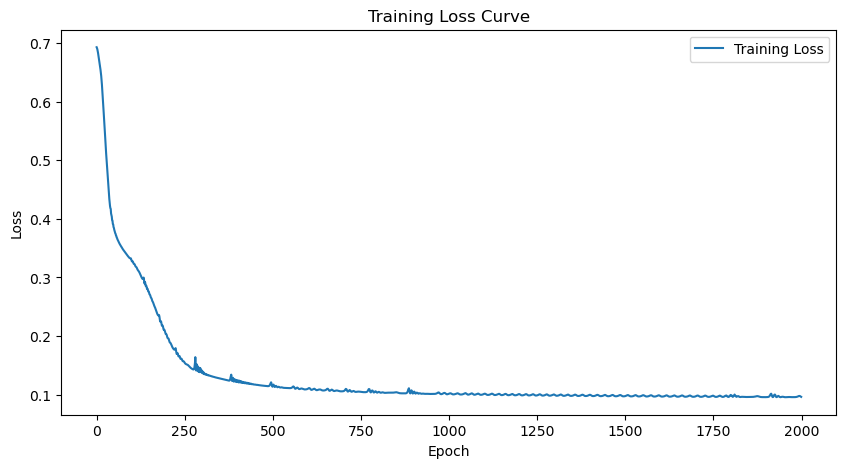

Final Model Accuracy: 81.84%
Final Model F1-score: 0.8262


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 81.84%
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



/tmp/ipykernel_345913/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
